# Tutorial: distribution space coupling in *one-dimensional* space

## Install/import dependencies

Please install the following dependencies:
 - NumPy
 - Jax
 - Matplotlib

In [353]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

import jax
from jax.scipy.stats import multivariate_normal as mvn
key = jax.random.PRNGKey(0)

import matplotlib.pyplot as plt

## Initialization

First, let's create two one-dimensional agents, with their initial preference, $p_1(x)$ and $p_2(x)$, distributions represented by two normal distributions

In [354]:
mu1 = 0.02
sig1 = 0.1

mu2 = -0.03
sig2 = 0.2

Then, let's compute the preference distributions over a one-dimensional state space $x\in[-1, 1]$

In [355]:
xlist = np.linspace(-1, 1, 201)
dx = xlist[1] - xlist[0]

In [356]:
pdf_agent1 = mvn.pdf(xlist, mu1, sig1**2)
pdf_agent1_origin = pdf_agent1.copy()
pdf_agent2 = mvn.pdf(xlist, mu2, sig2**2)
pdf_agent2_origin = pdf_agent2.copy()

And let's plot them out.

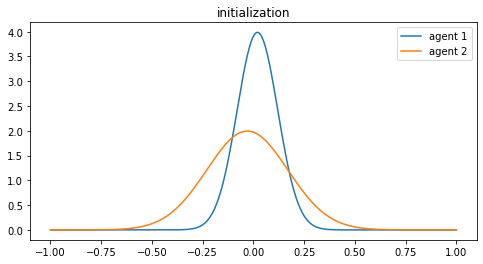

In [357]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(xlist, pdf_agent1, color='C0', label='agent 1')
ax.plot(xlist, pdf_agent2, color='C1', label='agent 2')
ax.set_title('initialization')
ax.legend()
plt.show()

## Define interact function

Now, let's define an interact function, $\psi(x_1, x_2)$, which represents collision likelihood given two agents' states. Here we define it as another Gaussian likelihood function.

In [358]:
def coll(xd, c=0.003): # we take in x1 - x2 directly, the sign doesn't matter
    return mvn.pdf(xd, mean=0, cov=c)

And we can plot it.

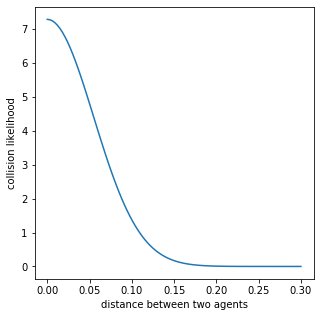

In [359]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(np.linspace(0, 0.3, 100), coll(np.linspace(0, 0.3, 100)))
ax.set_xlabel('distance between two agents')
ax.set_ylabel('collision likelihood')
plt.show()

With the interaction function, we can compute the joint expected collision likelihood as $\int\int \psi(x_1,x_2) p_1(x_1) p_2(x_2) dx_1 dx_2$. Here we approximate it through numerical integration.

In [360]:
def joint_expected_coll(pdf1, pdf2):
    grid_xdiff = xlist - xlist[:, np.newaxis]
    grid_coll = coll(grid_xdiff)
    grid_coll = grid_coll * pdf1
    grid_coll = grid_coll * pdf2[:, np.newaxis]
    res = grid_coll.sum() * dx ** 2
    return res

In [361]:
exp_coll = joint_expected_coll(pdf_agent1, pdf_agent2)
print('expected collision likelihood for initial preferences: ', exp_coll)

expected collision likelihood for initial preferences:  1.6925027


## Measure preference deviation

We also need to measure the deviation of each agent's preferences in different iterations. Here we use the KL-divergence as the measure.

In [362]:
def pref_dev(pdf_i, pdf_j):
    inner_log = np.log(pdf_i / (pdf_j + 1e-08)) # add 1e-08 to avoid overflow
    inner_log = np.nan_to_num(inner_log, nan=0, neginf=0, posinf=0)
    return np.sum(pdf_i * inner_log) * dx

In [363]:
print('preference deviation between agent 1 and 2: ', pref_dev(pdf_agent1, pdf_agent2))

preference deviation between agent 1 and 2:  0.34939718


## DistNav optimization on one-dimensional preferences

Now, we can finally start to optimize for optimal preference distributoins for the two agents. Here we use the iterative best response (IBR), so we will first update agent 1's preference while assuming agent 2's preference won't change during the update. 

To update agent 1's preference $p_1^{(k)}(x)$ in iteration $k$, we formulate the following subproblem:
$$
p_1^{(k)}(x) = \arg\min_p \int\int \psi(x,x_2) p(x) p_2(x_2) dx dx_2 + \int p(x) \log\left(\frac{p(x)}{p_1^{(k-1)}(x)}\right) dx
$$

And the global minimum for this problem is (proof can be found in the [paper](http://www.roboticsproceedings.org/rss17/p053.pdf)): 
$$
p_1^{(k)}(x) = \eta \cdot p_1^{(k-1)}(x) \exp\left(-\int \psi(x,x_2) p_2(x_2) dx_2\right)
$$ where $\eta$ is the normalization term.

Let's implement this update below, again we will approximate it through numerical integration.

In [364]:
def update_agent(pdf_agent1, pdf_agent2):
    '''
    update first agent's preference while fixing the second one
    '''
    # compute the integral inside the brackets
    grid_xdiff = xlist - xlist[:, np.newaxis]
    grid_coll = coll(grid_xdiff)
    inner_integral = np.sum(grid_coll * pdf_agent2, axis=1) * dx
    # update agent 1's preference
    new_pdf = pdf_agent1 * np.exp(-inner_integral)
    # normalize it
    new_pdf /= np.sum(new_pdf) * dx
    return new_pdf

In [365]:
new_pdf_agent1 = update_agent(pdf_agent1, pdf_agent2)

And let's plot the new preference for agent 1.

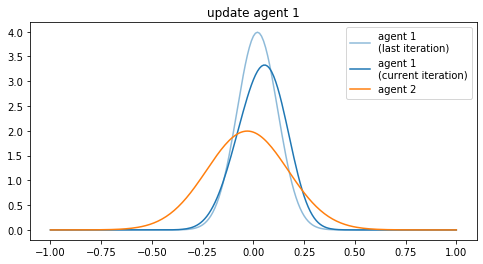

In [366]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(xlist, pdf_agent1, color='C0', label='agent 1\n(last iteration)', alpha=0.5)
ax.plot(xlist, new_pdf_agent1, color='C0', label='agent 1\n(current iteration)', alpha=1.0)
ax.plot(xlist, pdf_agent2, color='C1', label='agent 2')
ax.set_title('update agent 1')
ax.legend()
plt.show()

And similarly, we can update agent 2's preference while fixing the new preference of agent 1.

In [367]:
new_pdf_agent2 = update_agent(pdf_agent2, new_pdf_agent1)

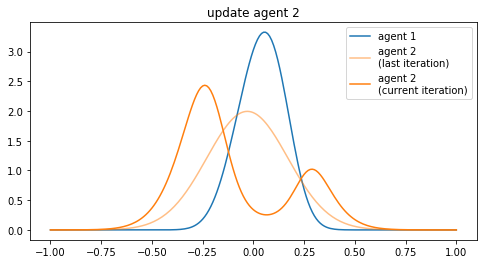

In [368]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(xlist, new_pdf_agent1, color='C0', label='agent 1')
ax.plot(xlist, pdf_agent2, color='C1', label='agent 2\n(last iteration)', alpha=0.5)
ax.plot(xlist, new_pdf_agent2, color='C1', label='agent 2\n(current iteration)', alpha=1.0)
ax.set_title('update agent 2')
ax.legend()
plt.show()

Based on the above udpates, we can optimize for optimal preferences iteratively. Here we terminate the iteration when the joint expected collision risk is below a threshold.

In [369]:
thred = 0.01
exp_coll_list = [joint_expected_coll(pdf_agent1, pdf_agent2)]
pref_dev_agent1_list = []
pref_dev_agent2_list = []

it = 0
while True:
    new_pdf_agent1 = update_agent(pdf_agent1, pdf_agent2)
    new_pdf_agent2 = update_agent(pdf_agent2, new_pdf_agent1)
    
    pref_dev_agent1 = pref_dev(new_pdf_agent1, pdf_agent1)
    pref_dev_agent1_list.append(pref_dev_agent1)
    pref_dev_agent2 = pref_dev(new_pdf_agent2, pdf_agent2)
    pref_dev_agent2_list.append(pref_dev_agent2)
    
    pdf_agent1 = new_pdf_agent1.copy()
    pdf_agent2 = new_pdf_agent2.copy()
    
    if exp_coll_list[-1] < thred:
        print('converged at: ', exp_coll_list[-1])
        break
    
    print('iter {}: {}'.format(it, exp_coll_list[-1]))
    exp_coll_list.append(joint_expected_coll(pdf_agent1, pdf_agent2))
    it += 1

iter 0: 1.692502737045288
iter 1: 0.6442658305168152
iter 2: 0.1861129254102707
iter 3: 0.07021001726388931
iter 4: 0.03715832903981209
iter 5: 0.023803533986210823
iter 6: 0.01701255328953266
iter 7: 0.013035846874117851
iter 8: 0.010476273484528065
converged at:  0.008712838


Optimal state for each agent can be found as the maximum of the converged preference.

In [370]:
opt_x_agent1 = xlist[np.argmax(pdf_agent1)]
opt_p_agent1 = pdf_agent1[np.argmax(pdf_agent1)]
print('optimal states for agent 1: {}, with preference: {}'.format(opt_x_agent1, opt_p_agent1))
opt_x_agent2 = xlist[np.argmax(pdf_agent2)]
opt_p_agent2 = pdf_agent2[np.argmax(pdf_agent2)]
print('optimal states for agent 2: {}, with preference: {}'.format(opt_x_agent2, opt_p_agent2))

optimal states for agent 1: 0.06000000000000005, with preference: 5.7082061767578125
optimal states for agent 2: -0.26, with preference: 3.735023260116577


Let's plot the converged preferences.

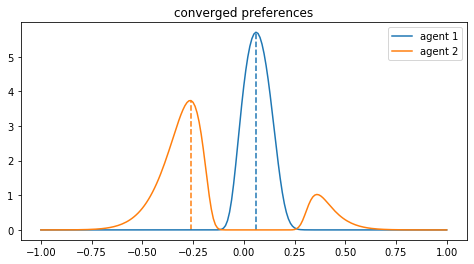

In [371]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(xlist, pdf_agent1, color='C0', label='agent 1')
ax.vlines([opt_x_agent1], ymin=0, ymax=opt_p_agent1, color='C0', linestyle='--')
ax.plot(xlist, pdf_agent2, color='C1', label='agent 2')
ax.vlines([opt_x_agent2], ymin=0, ymax=opt_p_agent2, color='C1', linestyle='--')
ax.set_title('converged preferences')
ax.legend()
plt.show()

We can also plot the iterations.

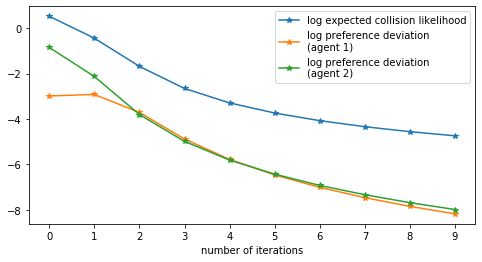

In [372]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.log(exp_coll_list), color='C0', marker='*', label='log expected collision likelihood')
ax.plot(np.log(pref_dev_agent1_list), color='C1', marker='*', label='log preference deviation\n(agent 1)')
ax.plot(np.log(pref_dev_agent2_list), color='C2', marker='*', label='log preference deviation\n(agent 2)')
ax.set_xticks(np.arange(it+1))
ax.set_xlabel('number of iterations')
ax.legend()
plt.show()

## Use samples to approximate the DistNav update

As seen above, the analytical solution for DistNav updates is expensive to compute, so in practice (especially when agent trajectories have higher dimensions), we use samples to approximate the update.

First, we generate samples from the original preferences, and we initialize samples with all weights being 1.

In [373]:
num_samples = 500
samples_agent1 = (jax.random.normal(key, [num_samples]) * sig1) + mu1
weights_agent1 = np.ones_like(samples_agent1, dtype=float)
samples_agent2 = (jax.random.normal(key, [num_samples]) * sig2) + mu2
weights_agent2 = np.ones_like(samples_agent2, dtype=float)

Also, we need to compute the original preferences of these samples.

In [374]:
sample_pdf_agent1 = mvn.pdf(x=samples_agent1, mean=mu1, cov=sig1**2)
sample_pdf_agent2 = mvn.pdf(x=samples_agent2, mean=mu2, cov=sig2**2)

We can plot the sampels now, here the height of each sample is its weight times the original preference, which approximates the value of posterior preference at this point.

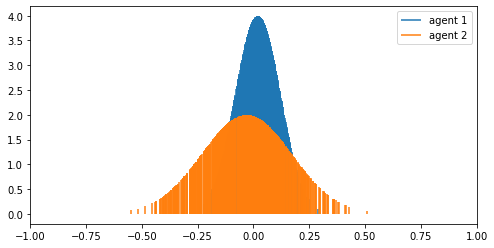

In [375]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.vlines(samples_agent1, 
          ymin=np.zeros_like(samples_agent1), 
          ymax=weights_agent1*sample_pdf_agent1,
          color='C0', label='agent 1')
ax.vlines(samples_agent2, 
          ymin=np.zeros_like(samples_agent2), 
          ymax=weights_agent1*sample_pdf_agent2,
          color='C1', label='agent 2')
ax.legend()
ax.set_xlim(-1, 1)
plt.show()

We can use the generated samples to approximate the expected collision likelihood. The original integration is now replaced by the Monte-Carlo integration from the samples.

In [376]:
def joint_expected_coll_mc(samples1, samples2, weights1, weights2):
    grid_xdiff = samples1 - samples2[:, np.newaxis]
    grid_coll = coll(grid_xdiff)
    grid_coll = grid_coll * weights1
    grid_coll = grid_coll * weights2[:, np.newaxis]
    res = grid_coll.sum() / (num_samples ** 2)
    return res

In [377]:
exp_coll_mc = joint_expected_coll_mc(samples_agent1, samples_agent2, weights_agent1, weights_agent2)
print('expected collision likelihood (MC integration): ', exp_coll_mc)

expected collision likelihood (MC integration):  1.6752884


Similarly, we can approximate the KL-divergence through Monte-Carlo integration. Note that, for the same agent, the sample values are fixed, only the weights will change in iterations. 

In [378]:
def pref_dev_mc(samples_pdf, weights_i, weights_j):
    inner_log = np.log(weights_i / (weights_j + 1e-08)) # add 1e-08 to avoid overflow
    inner_log = np.nan_to_num(inner_log, nan=0, neginf=0, posinf=0)
    return np.sum(inner_log * weights_i) / num_samples

Now it's time to approximate the DistNav update through Monte-Carlo integration. 

In [379]:
def update_agent_mc(samples1, samples2, weights1, weights2):
    '''
    update first agent's preference while fixing the second one
    '''
    # compute the integral inside the brackets
    grid_xdiff = samples1 - samples2[:, np.newaxis]
    grid_coll = coll(grid_xdiff)
    inner_integral = np.sum(grid_coll * weights2[:, np.newaxis], axis=0) / num_samples
    # update agent 1's preference
    new_weights = weights1 * np.exp(-inner_integral)
    # normalize it
    new_weights /= np.sum(new_weights) / num_samples
    return new_weights

Let's update the weights for agent 1's samples.

In [380]:
new_weights_agent1 = update_agent_mc(samples_agent1, samples_agent2, weights_agent1, weights_agent2)

Plot the samples to see if they match with numerical integration.

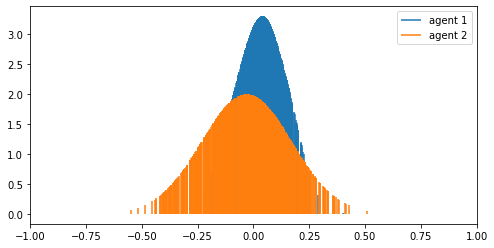

In [381]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.vlines(samples_agent1, 
          ymin=np.zeros_like(samples_agent1), 
          ymax=new_weights_agent1*sample_pdf_agent1,
          color='C0', label='agent 1')
ax.vlines(samples_agent2, 
          ymin=np.zeros_like(samples_agent2), 
          ymax=weights_agent1*sample_pdf_agent2,
          color='C1', label='agent 2')
ax.legend()
ax.set_xlim(-1, 1)
plt.show()

And then we can update agent 2's sample weights with the new sample weights from agent 1.

In [382]:
new_weights_agent2 = update_agent_mc(samples_agent2, samples_agent1, weights_agent2, new_weights_agent1)

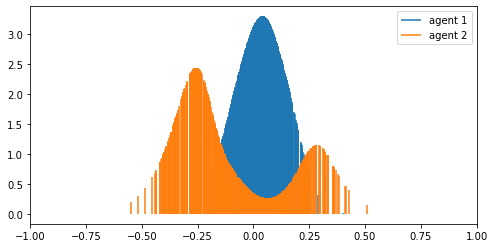

In [383]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.vlines(samples_agent1, 
          ymin=np.zeros_like(samples_agent1), 
          ymax=new_weights_agent1*sample_pdf_agent1,
          color='C0', label='agent 1')
ax.vlines(samples_agent2, 
          ymin=np.zeros_like(samples_agent2), 
          ymax=new_weights_agent2*sample_pdf_agent2,
          color='C1', label='agent 2')
ax.legend()
ax.set_xlim(-1, 1)
plt.show()

Similarly, we can update the sample weights iteratively.

In [384]:
thred = 0.01
exp_coll_list = [joint_expected_coll_mc(samples_agent1, samples_agent2, weights_agent1, weights_agent2)]
pref_dev_agent1_list = []
pref_dev_agent2_list = []

it = 0
while True:
    new_weights_agent1 = update_agent_mc(samples_agent1, samples_agent2, weights_agent1, weights_agent2)
    new_weights_agent2 = update_agent_mc(samples_agent2, samples_agent1, weights_agent2, new_weights_agent1)
    
    pref_dev_agent1 = pref_dev_mc(sample_pdf_agent1, new_weights_agent1, weights_agent1)
    pref_dev_agent1_list.append(pref_dev_agent1)
    pref_dev_agent2 = pref_dev_mc(sample_pdf_agent2, new_weights_agent2, weights_agent2)
    pref_dev_agent2_list.append(pref_dev_agent2)
    
    weights_agent1 = new_weights_agent1.copy()
    weights_agent2 = new_weights_agent2.copy()
    
    if exp_coll_list[-1] < thred or it > 25:
        print('converged at: ', exp_coll_list[-1])
        break
    
    print('iter {}: {}'.format(it, exp_coll_list[-1]))
    exp_coll_list.append(joint_expected_coll_mc(samples_agent1, samples_agent2, weights_agent1, weights_agent2))
    it += 1

iter 0: 1.6752883195877075
iter 1: 0.5965263247489929
iter 2: 0.1745682954788208
iter 3: 0.07014438509941101
iter 4: 0.037635285407304764
iter 5: 0.02378123626112938
iter 6: 0.016655616462230682
iter 7: 0.012525588274002075
converged at:  0.009918601


Optimal state for each agent can be approximated as the sample with largest value of weight times original preference. 

In [385]:
opt_x_agent1_mc = samples_agent1[np.argmax(weights_agent1 * sample_pdf_agent1)]
opt_p_agent1 = np.max(weights_agent1 * sample_pdf_agent1)
print('optimal states for agent 1: {}, with preference: {}'.format(opt_x_agent1, opt_p_agent1))
opt_x_agent2 = samples_agent2[np.argmax(weights_agent2 * sample_pdf_agent2)]
opt_p_agent2 = np.max(weights_agent2 * sample_pdf_agent2)
print('optimal states for agent 2: {}, with preference: {}'.format(opt_x_agent2, opt_p_agent2))

optimal states for agent 1: 0.06000000000000005, with preference: 5.38679313659668
optimal states for agent 2: -0.28115105628967285, with preference: 3.6536645889282227


And let's plot the coverged preference distributions through samples.

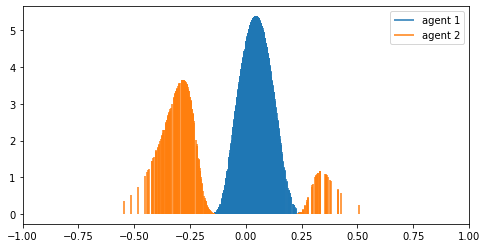

In [386]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.vlines(samples_agent1, 
          ymin=np.zeros_like(samples_agent1), 
          ymax=weights_agent1*sample_pdf_agent1,
          color='C0', label='agent 1')
ax.vlines(samples_agent2, 
          ymin=np.zeros_like(samples_agent2), 
          ymax=weights_agent2*sample_pdf_agent2,
          color='C1', label='agent 2')
ax.legend()
ax.set_xlim(-1, 1)
plt.show()

We can also plot the iterations.

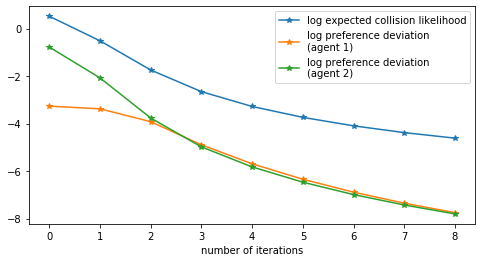

In [387]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.log(exp_coll_list), color='C0', marker='*', label='log expected collision likelihood')
ax.plot(np.log(pref_dev_agent1_list), color='C1', marker='*', label='log preference deviation\n(agent 1)')
ax.plot(np.log(pref_dev_agent2_list), color='C2', marker='*', label='log preference deviation\n(agent 2)')
ax.set_xticks(np.arange(it+1))
ax.set_xlabel('number of iterations')
ax.legend()
plt.show()